## Lab 6 - Wordnet (słowosieć)

In [1]:
import json
import math
import requests

from queue import SimpleQueue

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def send_request(operation=''):
    base_url = 'http://api.slowosiec.clarin-pl.eu/plwordnet-api/'
    return json.loads(requests.get(base_url + operation).content.decode("utf-8"))

### Task 3
All meanings of the noun **szkoda** and their synonyms.

In [3]:
# get all meanings
result = send_request('senses/search?lemma=szkoda&partOfSpeech=noun')
meanings_synonyms = {x['id']: {'meaning': x['domain']['description'] , 'synonyms': []} for x in result['content']}
for meaning_id in meanings_synonyms.keys():
    # get synset_id for a meaning
    synset_id = send_request('senses/{}/synset'.format(meaning_id))['id']
    # get meanings along with lemma (synonym) for synset
    result = send_request('synsets/{}/senses'.format(synset_id))
    meanings_synonyms[meaning_id]['synonyms'] = [x['lemma']['word'] for x in result]

for results_dict in meanings_synonyms.values():
    print(results_dict['meaning'] + ":")
    for s in results_dict['synonyms']:
        print('\t' + s)

plWN miejsca i umiejscowienie:
	szkoda
plWN posiadanie i jego zmiana:
	strata
	utrata
	szkoda
	uszczerbek


### Task 4
Closure of hypernymy relation for the first meaning of the **wypadek drogowy** expression.

Arrow on graph point FROM the hypernyms.

In [4]:
def get_synset_id_for_expression(expression, part_of_speech=None, meaning_no=1):
    try:
        # get first meaning
        api_call = 'senses/search?lemma={}'.format(expression)
        if part_of_speech:
            api_call += '&partOfSpeech=noun'.format(part_of_speech)
        result = send_request(api_call)
        meaning_id = result['content'][meaning_no-1]['id']
        # get synset_id for a meaning
        return send_request('senses/{}/synset'.format(meaning_id))['id']
    except IndexError:  # in task 7 not all names were found
        print("{}{} not found.".format(expression, meaning_no))


def draw_directed_graph(edges, graph_size=(12, 8)):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    plt.figure(figsize=graph_size)
    nx.draw(G, with_labels=True)


def map_synset_ids_to_expressions(synset_ids):
    return tuple("\n".join([meaning["lemma"]["word"] for meaning in send_request("synsets/{}/senses".format(id))]) for id in synset_ids)
    

def find_relations(synset_id, relation_name, max_depth=10000):
    queue = SimpleQueue()
    relations = []
    depth = 0
    
    results = [(x['synsetFrom']['id'], x['synsetTo']['id']) for x in send_request("synsets/{}/relations/to".format(synset_id)) if x['relation']['name'] == relation_name]
    
    for rel in results:
        queue.put((rel, depth))
    
    while not queue.empty():
        current_rel, depth = queue.get()
        if depth >= max_depth:
            break
        relations.append(map_synset_ids_to_expressions(current_rel))
        results = [(x['synsetFrom']['id'], x['synsetTo']['id']) for x in send_request("synsets/{}/relations/to".format(current_rel[0])) if x['relation']['name'] == relation_name]
        for rel in results:
            queue.put((rel, depth + 1))

    return relations

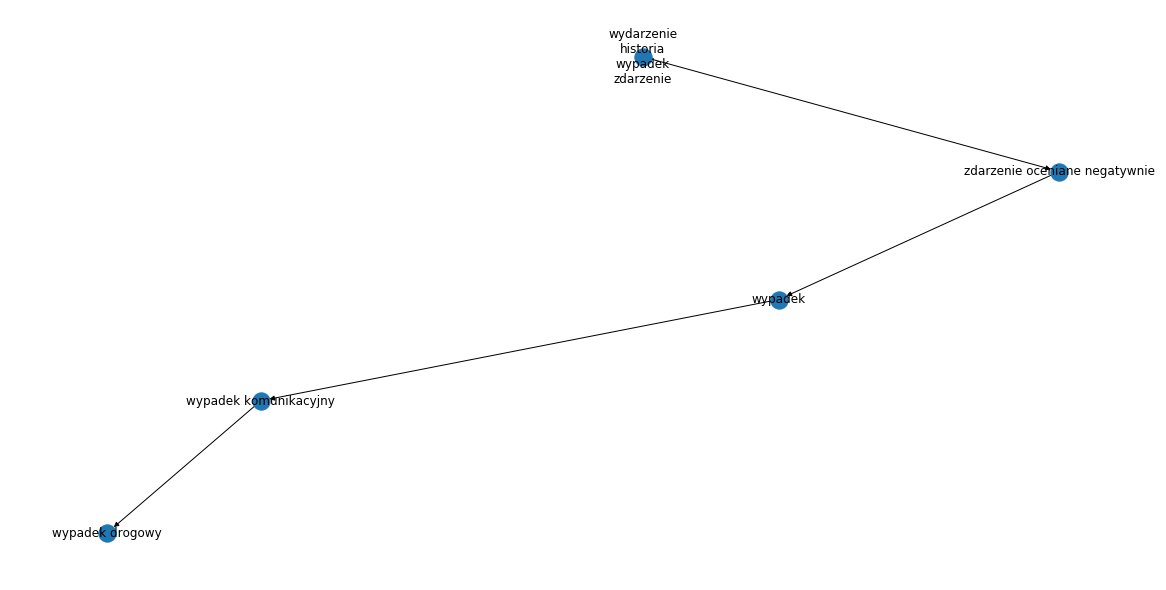

In [5]:
synset_id = get_synset_id_for_expression("wypadek drogowy")

relations = find_relations(synset_id, 'hiperonimia')
draw_directed_graph(relations, graph_size=(16, 8))

### Task 5
Find direct hyponyms of **wypadek**1 noun.

Now arrows point FROM the hyponyms.

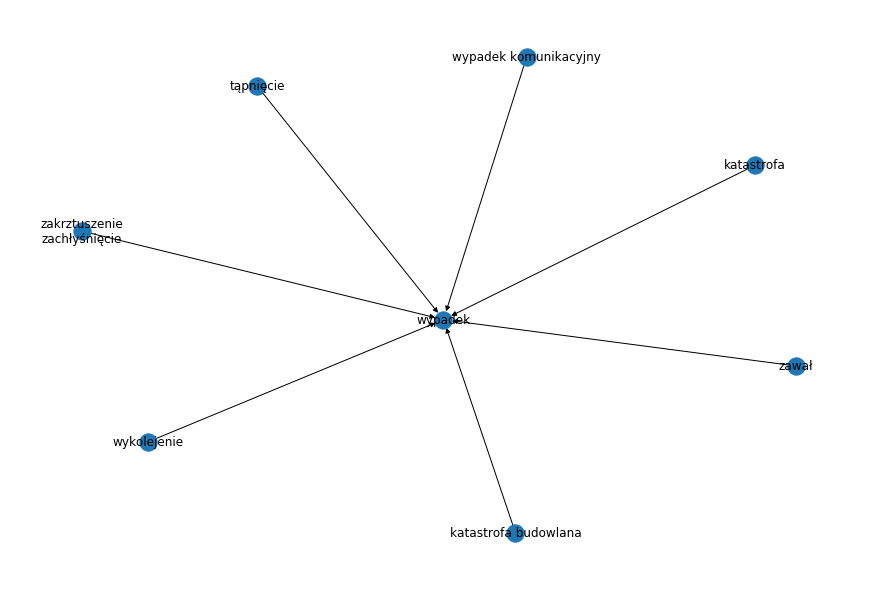

In [6]:
synset_id = get_synset_id_for_expression("wypadek", part_of_speech="noun", meaning_no=1)

relations = find_relations(synset_id, 'hiponimia', max_depth=1)
draw_directed_graph(relations, graph_size=(12, 8))

### Task 6
Second-order hyponyms of the same noun.

Arrows point FROM the hyponyms.

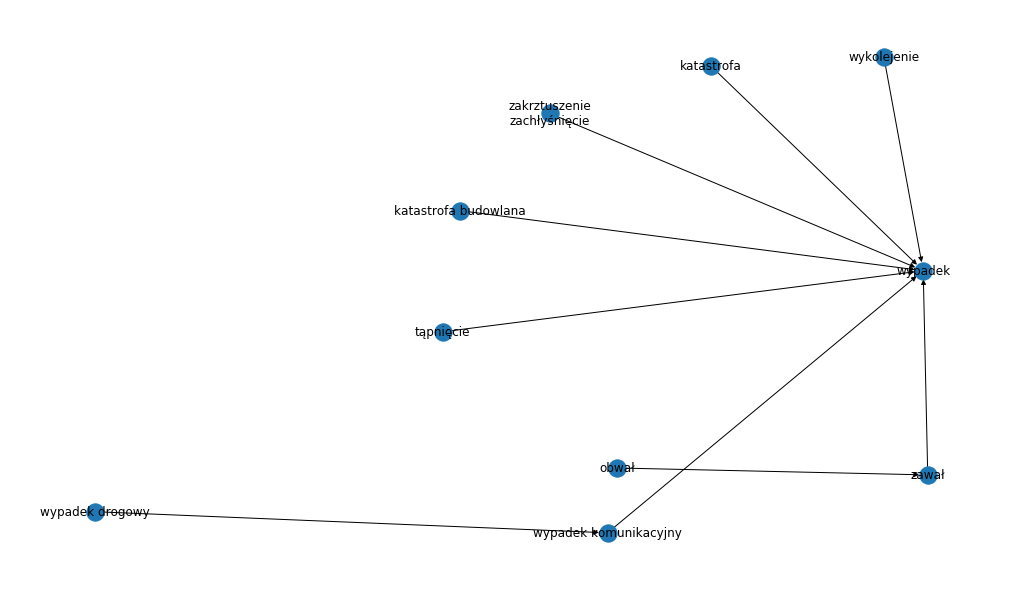

In [7]:
synset_id = get_synset_id_for_expression("wypadek", part_of_speech="noun", meaning_no=1)

relations = find_relations(synset_id, 'hiponimia', max_depth=2)
draw_directed_graph(relations, graph_size=(14, 8))

### Task 7 
Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:
- szkoda2, strata1, uszczerbek1, szkoda majątkowa1, uszczerbek na zdrowiu1, krzywda1, niesprawiedliwość1, nieszczęście2.
- wypadek1, wypadek komunikacyjny1, kolizja2, zderzenie2, kolizja drogowa1, bezkolizyjny2, katastrofa budowlana1, wypadek drogowy1.


Here I am treating that e.g. arrow with the label 'hiponimia' points FROM the nodes' hyponym.  
( X - hiponimia -> Y  = X is a hyponym of Y)

In [8]:
def draw_directed_graph_with_labels(edges, edge_labels):
    G = nx.DiGraph()
    for edge in edges:
        G.add_edge(*edge, label=edge_labels[edge])
     
    pos = nx.spring_layout(G)
    plt.figure(figsize=(16, 8))
    nx.draw(G, pos=pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


def display_graph_for_group(group):
    edges = []
    edge_labels = {}
    synset_ids = []
    
    for word, meaning_no in group:
        synset_id = get_synset_id_for_expression(word, meaning_no=meaning_no)
        if synset_id:
            synset_ids.append(synset_id)
    
    for synset_id in synset_ids:
        for rel in send_request("synsets/{}/relations/to".format(synset_id)):
            synset_pair = (rel["synsetFrom"]["id"], rel["synsetTo"]["id"])
            relation_name = rel['relation']['name']
            
            # filtering to only have expressions from groups, can be commented out
            if any([x not in synset_ids for x in synset_pair]):
                continue
                                
            synset_pair = map_synset_ids_to_expressions(synset_pair)
            # not to get bidirectional edges with both labels on top of each other
            if synset_pair not in edges and (synset_pair[1], synset_pair[0]) not in edges:
                edges.append(synset_pair)
                edge_labels[synset_pair] = relation_name
    
    draw_directed_graph_with_labels(edges, edge_labels=edge_labels)

szkoda majątkowa1 not found.


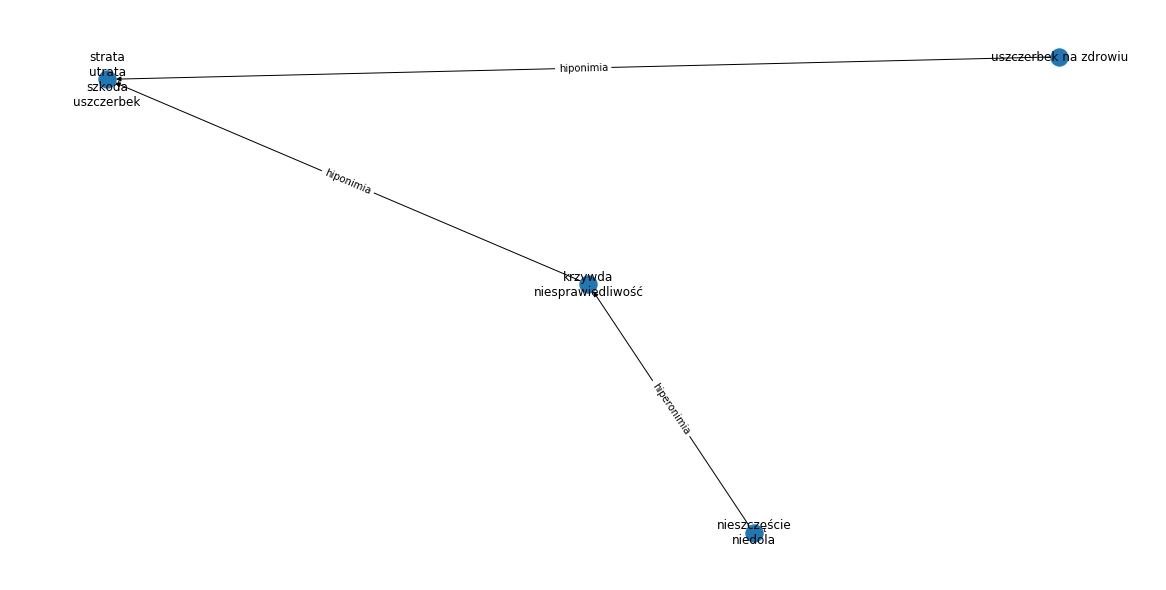

In [9]:
group1 = [("szkoda", 2), ("strata", 1), ("uszczerbek", 1), ("szkoda majątkowa", 1), ("uszczerbek na zdrowiu", 1), ("krzywda", 1), ("niesprawiedliwość", 1), ("nieszczęście", 2)]
display_graph_for_group(group1)

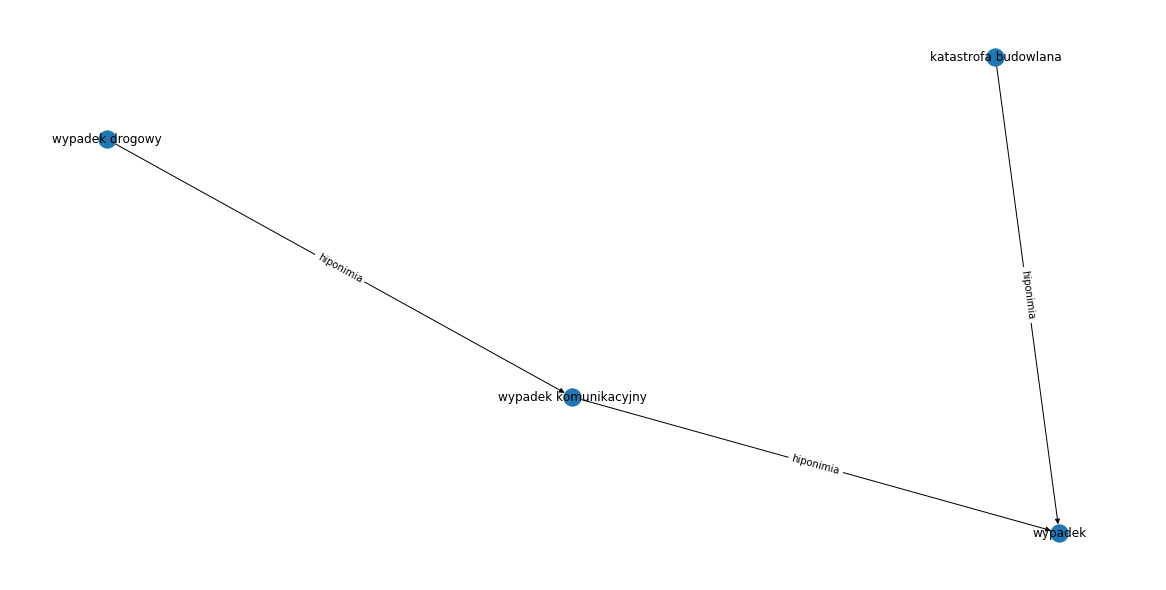

In [10]:
group2 = [("wypadek",1), ("wypadek komunikacyjny", 1), ("kolizja", 2), ("zderzenie", 2), ("kolizja drogowa", 1), ("bezkolizyjny", 2), ("katastrofa budowlana", 1), 
          ("wypadek drogowy", 1)]
display_graph_for_group(group2)

### Task 8
Find the value of Leacock-Chodorow semantic similarity measure between following pairs of lexemes:  
- **szkoda**2 - **wypadek**1,
- **kolizja**2 - **szkoda majątkowa**1,
- **nieszczęście**2 - **katastrofa budowlana**1.

`LCH_Similiarity = log(p/(2*d))`  
where p - length of shortest path, d - taxonomy depth  
From http://www.nltk.org/howto/wordnet.html

In [11]:
def get_LCH_metric_value(p, d):
    return math.log(p/(2 * d))


def calculate_distance_bfs(synset_id_1, synset_id_2, depth):    
    queue = SimpleQueue()
    visited = set()
    shortest_path = 0
    
    queue.put((synset_id_1, 0))
        
    while queue:
        next_synset_id, distance = queue.get()
        
        if next_synset_id not in visited: 
            visited.add(next_synset_id)
            relations = send_request('synsets/{}/relations'.format(next_synset_id))
              
            for relation in relations:
                
                synset_to_id = relation['synsetTo']['id']
                                
                if synset_to_id == synset_id_2:
                    return distance + 1
                
                if distance < depth:
                    queue.put((synset_to_id, distance + 1))

    return -1

In [ ]:
depth = 20

for lexems in [(('szkoda', 2), ('wypadek', 1)), (('kolizja', 2), ('szkoda majątkowa', 1)), (('nieszczęście', 2), ('katastrofa budowlana', 1))]:
    synset_id_1 = get_synset_id_for_expression(lexems[0][0], part_of_speech="noun", meaning_no=lexems[0][1])
    synset_id_2 = get_synset_id_for_expression(lexems[1][0], part_of_speech="noun", meaning_no=lexems[1][1])
    
    if synset_id_1 and synset_id_2:
        shortest_path = calculate_distance_bfs(synset_id_1, synset_id_2, depth)
        
        if shortest_path > -1:
            value = get_LCH_metric_value(shortest_path, depth)
            print("{} - {} : LCH = {}".format(lexems[0][0], lexems[1][0], value))
        else:
            print("{} - {} : Path between not found!".format(lexems[0][0], lexems[1][0]))

In [12]:
### Task 9
#### What is the necessary step to use the knowledge from dictionaries such as WordNet?
Getting to know the dictionary's structure (here, for example relations), API capabilities - here we have a lot of possible operations and used only a few of them.
#### Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).
Barely any value. WordNet only works on expressions so it can't give any information about a whole sentence, only thing we get is words' meaning which could give some information about sentence's subject.
#### Discuss the problmes comming from using structured knowledge resources such as WordNet.
Complexity of the structure poses problems when analysing relations. When traversing this net we can easily choose the wrong "branch" (picking the wrong meaning for an ambiguous word), then the result can be completely different from the correct one.

szkoda - wypadek : LCH = -2.5902671654458267
szkoda majątkowa1 not found.
nieszczęście - katastrofa budowlana : LCH = -2.0794415416798357


### Task 9
#### What is the necessary step to use the knowledge from dictionaries such as WordNet?
Getting to know the dictionary's structure (here, for example relations), API capabilities - here we have a lot of possible operations and used only a few of them.
#### Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).
Barely any value. WordNet only works on expressions so it can't give any information about a whole sentence, only thing we get is words' meaning which could give some information about sentence's subject.
#### Discuss the problmes comming from using structured knowledge resources such as WordNet.
Complexity of the structure poses problems when analysing relations. When traversing this net we can easily choose the wrong "branch" (picking the wrong meaning for an ambiguous word), then the result can be completely different from the correct one.